<a href="https://colab.research.google.com/github/onewon1234/AI_DL_Project/blob/main/BERT/%20klue_bert_pairwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# KLUE-BERT Pairwise Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° Î™®Îç∏ (ÏàòÏ†ïÎêú Î≤ÑÏ†Ñ)

# 1. ÌïÑÏöîÌïú ÎùºÏù¥Î∏åÎü¨Î¶¨ import
import pandas as pd
import numpy as np
import re
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from scipy.stats import loguniform
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
import itertools
from itertools import permutations
from transformers import (
    AutoTokenizer,
    AutoModel,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import os
os.environ["WANDB_DISABLED"] = "true"

print("ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å")

ÎùºÏù¥Î∏åÎü¨Î¶¨ import ÏôÑÎ£å


In [2]:
# ÌôòÍ≤Ω ÌôïÏù∏
print(f"PyTorch Î≤ÑÏ†Ñ: {torch.__version__}")
print(f"CUDA ÏÇ¨Ïö© Í∞ÄÎä•: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA ÎîîÎ∞îÏù¥Ïä§: {torch.cuda.get_device_name(0)}")

PyTorch Î≤ÑÏ†Ñ: 2.6.0+cu124
CUDA ÏÇ¨Ïö© Í∞ÄÎä•: True
CUDA ÎîîÎ∞îÏù¥Ïä§: Tesla T4


In [3]:
# Google Drive ÎßàÏö¥Ìä∏
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Îç∞Ïù¥ÌÑ∞ Î°úÎìú
train = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/train.csv')
test = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/test.csv')
submission = pd.read_csv('/content/drive/MyDrive/data/daycon_sentence/sample_submission.csv')

In [5]:
print("=== Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å ===")
print(f"Train Îç∞Ïù¥ÌÑ∞: {len(train)} ÏÉòÌîå")
print(f"Test Îç∞Ïù¥ÌÑ∞: {len(test)} ÏÉòÌîå")
print(f"Submission ÌòïÏãù: {submission.shape}")

=== Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å ===
Train Îç∞Ïù¥ÌÑ∞: 7351 ÏÉòÌîå
Test Îç∞Ïù¥ÌÑ∞: 1780 ÏÉòÌîå
Submission ÌòïÏãù: (1780, 5)


In [6]:
# Îç∞Ïù¥ÌÑ∞ Í∏∞Î≥∏ Ï†ïÎ≥¥ ÌôïÏù∏
print("=== Train Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===")
train.info()
print("\n=== Test Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===")
test.info()
print("\n=== Submission ÌòïÏãù ===")
submission.info()

=== Train Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7351 entries, 0 to 7350
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          7351 non-null   object
 1   sentence_0  7351 non-null   object
 2   sentence_1  7351 non-null   object
 3   sentence_2  7351 non-null   object
 4   sentence_3  7351 non-null   object
 5   answer_0    7351 non-null   int64 
 6   answer_1    7351 non-null   int64 
 7   answer_2    7351 non-null   int64 
 8   answer_3    7351 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 517.0+ KB

=== Test Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780 entries, 0 to 1779
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          1780 non-null   object
 1   sentence_0  1780 non-null   object
 2   sentence_1  1780 non-null   object
 3   sentence_2  1780 non-null   o

In [7]:
# ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ìï®Ïàò
def clean_text(text):
    # ÌäπÏàòÎ¨∏Ïûê Ï†úÍ±∞
    text = re.sub(r'[^\w\s]', '', text)
    # ÏÜåÎ¨∏Ïûê Î≥ÄÌôò: ÌïúÍ∏ÄÏóêÎäî Î¨¥ÏùòÎØ∏
    text = text.lower()
    # Î∂àÌïÑÏöîÌïú Í≥µÎ∞± Ï†úÍ±∞
    text = ' '.join(text.split())
    return text

In [8]:
# ÌÖçÏä§Ìä∏ Ï†ïÏ†ú Ï†ÅÏö©
for i in range(4):
    train[f'sentence_{i}'] = train[f'sentence_{i}'].apply(clean_text)
    test[f'sentence_{i}'] = test[f'sentence_{i}'].apply(clean_text)

print("ÌÖçÏä§Ìä∏ Ï†ïÏ†ú ÏôÑÎ£å")
print(f"Ï†ïÏ†ú Ï†ÑÌõÑ ÎπÑÍµê:")
print(f"Ï†ïÏ†ú Ï†Ñ: {train['sentence_0'].iloc[0]}")
print(f"Ï†ïÏ†ú ÌõÑ: {train['sentence_0'].iloc[0]}")

ÌÖçÏä§Ìä∏ Ï†ïÏ†ú ÏôÑÎ£å
Ï†ïÏ†ú Ï†ÑÌõÑ ÎπÑÍµê:
Ï†ïÏ†ú Ï†Ñ: Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§
Ï†ïÏ†ú ÌõÑ: Î∏îÎ°ùÏ≤¥Ïù∏ Í∏∞Ïà†ÏùÄ Ìà¨Ìëú Í≥ºÏ†ïÏùò Ìà¨Î™ÖÏÑ±ÏùÑ ÌÅ¨Í≤å Ìñ•ÏÉÅÏãúÌÇ¨ Ïàò ÏûàÎã§


In [9]:
## ‚úÖ Pairwise Ï†ÑÏ≤òÎ¶¨ Ìï®Ïàò
def preprocess_pairwise(df):
    """
    Î¨∏Ïû•Îì§ÏùÑ pairwise ÌòïÌÉúÎ°ú Î≥ÄÌôò
    Í∞Å Î¨∏Ïû• ÏåçÏóê ÎåÄÌï¥ Ïò¨Î∞îÎ•∏ ÏàúÏÑúÏù∏ÏßÄ Ïó¨Î∂ÄÎ•º Î†àÏù¥Î∏îÎßÅ
    """
    data = []
    for _, row in df.iterrows():
        sentences = [row[f'sentence_{i}'] for i in range(4)]
        answer = [row[f'answer_{i}'] for i in range(4)]

        # Ïò¨Î∞îÎ•∏ ÏàúÏÑúÎ°ú Ï†ïÎ†¨Îêú Î¨∏Ïû•Îì§
        ordered = [sentences[i] for i in answer]

        # Ïò¨Î∞îÎ•∏ ÏàúÏÑúÏùò ÏåçÎì§ (Ïó∞ÏÜçÎêú 3Í∞ú Ïåç)
        positive_pairs = [(ordered[i], ordered[i+1]) for i in range(3)]

        # Î™®Îì† Í∞ÄÎä•Ìïú ÏåçÎì§ (6Í∞ú)
        all_pairs = list(itertools.permutations(sentences, 2))

        # Í∞Å ÏåçÏóê ÎåÄÌï¥ Î†àÏù¥Î∏îÎßÅ
        for s1, s2 in all_pairs:
            label = 1 if (s1, s2) in positive_pairs else 0
            data.append({'sentence1': s1, 'sentence2': s2, 'label': label})

    return pd.DataFrame(data)

In [10]:
# Pairwise Îç∞Ïù¥ÌÑ∞ ÏÉùÏÑ±
pairwise_df = preprocess_pairwise(train)

print("=== Pairwise Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===")
pairwise_df.info()
print("\n=== ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ===")
print(pairwise_df['label'].value_counts())
print(f"\nÌÅ¥ÎûòÏä§ ÎπÑÏú®: {pairwise_df['label'].value_counts(normalize=True)}")

# ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï ÌôïÏù∏
num_zeros = pairwise_df['label'].value_counts()[0]
num_ones = pairwise_df['label'].value_counts()[1]
print(f"\nÌÅ¥ÎûòÏä§ 0 (ÏûòÎ™ªÎêú ÏàúÏÑú): {num_zeros}Í∞ú")
print(f"ÌÅ¥ÎûòÏä§ 1 (Ïò¨Î∞îÎ•∏ ÏàúÏÑú): {num_ones}Í∞ú")
print(f"Î∂àÍ∑†Ìòï ÎπÑÏú®: {num_zeros/num_ones:.2f}:1")

# ÌÅ¥ÎûòÏä§ Î∂àÍ∑†Ìòï Ìï¥Í≤∞ÏùÑ ÏúÑÌïú Í∞ÄÏ§ëÏπò Í≥ÑÏÇ∞
total = num_zeros + num_ones
weight_for_0 = total / (2 * num_zeros)
weight_for_1 = total / (2 * num_ones)

class_weights = torch.tensor([weight_for_0, weight_for_1], dtype=torch.float)
print("=== ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò ===")
print(f"ÌÅ¥ÎûòÏä§ 0 Í∞ÄÏ§ëÏπò: {weight_for_0:.4f}")
print(f"ÌÅ¥ÎûòÏä§ 1 Í∞ÄÏ§ëÏπò: {weight_for_1:.4f}")
print(f"Í∞ÄÏ§ëÏπò ÎπÑÏú®: {weight_for_1/weight_for_0:.2f}:1")


=== Pairwise Îç∞Ïù¥ÌÑ∞ Ï†ïÎ≥¥ ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88212 entries, 0 to 88211
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentence1  88212 non-null  object
 1   sentence2  88212 non-null  object
 2   label      88212 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.0+ MB

=== ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨ ===
label
0    66159
1    22053
Name: count, dtype: int64

ÌÅ¥ÎûòÏä§ ÎπÑÏú®: label
0    0.75
1    0.25
Name: proportion, dtype: float64

ÌÅ¥ÎûòÏä§ 0 (ÏûòÎ™ªÎêú ÏàúÏÑú): 66159Í∞ú
ÌÅ¥ÎûòÏä§ 1 (Ïò¨Î∞îÎ•∏ ÏàúÏÑú): 22053Í∞ú
Î∂àÍ∑†Ìòï ÎπÑÏú®: 3.00:1
=== ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò ===
ÌÅ¥ÎûòÏä§ 0 Í∞ÄÏ§ëÏπò: 0.6667
ÌÅ¥ÎûòÏä§ 1 Í∞ÄÏ§ëÏπò: 2.0000
Í∞ÄÏ§ëÏπò ÎπÑÏú®: 3.00:1


In [11]:
# 2. Îç∞Ïù¥ÌÑ∞ÏÖã Íµ¨ÏÑ±
MAX_TOKEN_LENGTH = 128

# Îç∞Ïù¥ÌÑ∞ÏÖã ÌÅ¥ÎûòÏä§ Ï†ïÏùò
class SentencePairDataset(Dataset):
    """
    Î¨∏Ïû• ÏåçÏùÑ Î∞õÏïÑ BERT ÏûÖÎ†• ÌòïÏãùÏúºÎ°ú Î≥ÄÌôòÌïòÎäî PyTorch Dataset ÌÅ¥ÎûòÏä§
    """
    def __init__(self, dataframe, tokenizer, max_length=MAX_TOKEN_LENGTH):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        encoding = self.tokenizer(
            row['sentence1'],
            row['sentence2'],
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        item = {
            'input_ids': encoding['input_ids'][0],
            'attention_mask': encoding['attention_mask'][0],
            'labels': torch.tensor(row['label'], dtype=torch.long)
        }

        if 'token_type_ids' in encoding:
            item['token_type_ids'] = encoding['token_type_ids'][0]

        return item

In [12]:
# 3. Î™®Îç∏ ÏïÑÌÇ§ÌÖçÏ≤ò (KLUE-BERT)
class SentencePairModel(nn.Module):
    def __init__(self, model_name, num_labels=2, class_weights=None):
        super(SentencePairModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)

        # ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπò Ï†ÅÏö©
        if class_weights is not None:
            self.loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        else:
            self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            output_hidden_states=True,
            return_dict=True
        )

        # ÎßàÏßÄÎßâ 4Í∞ú hidden layer ÌèâÍ∑† (ÏÑ±Îä• Ìñ•ÏÉÅ)
        hidden_states = outputs.hidden_states
        last_four = torch.stack(hidden_states[-4:])
        avg_hidden = torch.mean(last_four, dim=0)
        cls_output = avg_hidden[:, 0]

        cls_output = self.dropout(cls_output)
        logits = self.classifier(cls_output)

        loss = None
        if labels is not None:
            loss = self.loss_fn(logits, labels)

        return {'loss': loss, 'logits': logits}


In [13]:
# 4. ÌïôÏäµ ÏÑ§Ï†ï
# KLUE-BERT ÌÜ†ÌÅ¨ÎÇòÏù¥Ï†Ä Ï¥àÍ∏∞Ìôî
tokenizer = AutoTokenizer.from_pretrained('klue/bert-base')

# Îç∞Ïù¥ÌÑ∞ Î∂ÑÌï†: ÌïôÏäµ/Í≤ÄÏ¶ù (8:2)
train_df, val_df = train_test_split(
    pairwise_df,
    test_size=0.2,
    stratify=pairwise_df['label'],
    random_state=42
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [14]:
# dataset ÏÉùÏÑ±
train_dataset = SentencePairDataset(train_df, tokenizer, max_length=MAX_TOKEN_LENGTH)
val_dataset = SentencePairDataset(val_df, tokenizer, max_length=MAX_TOKEN_LENGTH)

print(f"Train Îç∞Ïù¥ÌÑ∞: {len(train_dataset)} ÏÉòÌîå")
print(f"Validation Îç∞Ïù¥ÌÑ∞: {len(val_dataset)} ÏÉòÌîå")
print(f"Train ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {train_df['label'].value_counts().to_dict()}")
print(f"Val ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {val_df['label'].value_counts().to_dict()}")

Train Îç∞Ïù¥ÌÑ∞: 70569 ÏÉòÌîå
Validation Îç∞Ïù¥ÌÑ∞: 17643 ÏÉòÌîå
Train ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {0: 52927, 1: 17642}
Val ÌÅ¥ÎûòÏä§ Î∂ÑÌè¨: {0: 13232, 1: 4411}


In [15]:
# GPU ÏÇ¨Ïö© Ïó¨Î∂Ä ÌôïÏù∏
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"ÏÇ¨Ïö© ÎîîÎ∞îÏù¥Ïä§: {device}")

ÏÇ¨Ïö© ÎîîÎ∞îÏù¥Ïä§: cuda


In [16]:
# ÌÅ¥ÎûòÏä§ Í∞ÄÏ§ëÏπòÎ•º ÎîîÎ∞îÏù¥Ïä§Î°ú Ïù¥Îèô
class_weights = class_weights.to(device)

# KLUE-BERT Î™®Îç∏ Ïù∏Ïä§ÌÑ¥Ïä§ ÏÉùÏÑ±
model = SentencePairModel("klue/bert-base", class_weights=class_weights).to(device)

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞Î°ú ÌÖåÏä§Ìä∏
sample = train_dataset[0]
print("\n=== ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ===")
print(f"Input IDs shape: {sample['input_ids'].shape}")
print(f"Attention Mask shape: {sample['attention_mask'].shape}")
print(f"Label: {sample['labels']}")

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]


=== ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ ÌôïÏù∏ ===
Input IDs shape: torch.Size([128])
Attention Mask shape: torch.Size([128])
Label: 1


In [17]:
# Í∞úÏÑ†Îêú ÌèâÍ∞Ä ÏßÄÌëú Ìï®Ïàò
def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=1)
    probs = torch.softmax(torch.tensor(logits), dim=1)

    # Í∏∞Î≥∏ ÏßÄÌëú
    accuracy = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, zero_division=0)
    precision = precision_score(labels, preds, zero_division=0)
    recall = recall_score(labels, preds, zero_division=0)

    # ROC-AUC (positive class ÌôïÎ•† ÏÇ¨Ïö©)
    try:
        auc = roc_auc_score(labels, probs[:, 1])
    except:
        auc = 0.0

    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc': auc
    }

In [18]:
# Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°ÏùÑ ÏúÑÌïú Ï∂îÍ∞Ä ÌèâÍ∞Ä ÏßÄÌëúÎì§
def compute_order_metrics(predictions, labels, original_data):
    """
    Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°ÏùÑ ÏúÑÌïú Îã§ÏñëÌïú ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞

    Args:
        predictions: Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º (pairwise)
        labels: Ïã§Ï†ú Î†àÏù¥Î∏î (pairwise)
        original_data: ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ (pairwise)
    """
    metrics = {}

    # 1. Sentence Accuracy (Í∞Å Î¨∏Ïû• ÏåçÏùò Ï†ïÌôïÎèÑ)
    sentence_accuracy = accuracy_score(labels, predictions)
    metrics['sentence_accuracy'] = sentence_accuracy

    # 2. Full Order Accuracy (Ï†ÑÏ≤¥ ÏàúÏÑúÍ∞Ä Ï†ïÌôïÌïú ÎπÑÏú®)
    # 6Í∞ú ÏåçÏî© Í∑∏Î£πÌôîÌïòÏó¨ Ï†ÑÏ≤¥ ÏàúÏÑú Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞
    full_order_correct = 0
    total_groups = len(predictions) // 6  # 6Í∞ú ÏåçÏî© Í∑∏Î£πÌôî

    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        # Ïù∏Îç±Ïä§ Î≤îÏúÑ ÌôïÏù∏
        if end_idx > len(predictions):
            break

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        # 4Í∞ú Î¨∏Ïû•Ïùò ÏàúÏÑúÎ•º Î≥µÏõê
        try:
            pred_order = reconstruct_order_from_pairs(group_preds)
            true_order = reconstruct_order_from_pairs(group_labels)

            # Î¶¨Ïä§Ìä∏ ÎπÑÍµêÎ°ú ÏàòÏ†ï
            if pred_order == true_order:
                full_order_correct += 1
        except Exception as e:
            print(f"ÏàúÏÑú Î≥µÏõê Ïò§Î•ò (Í∑∏Î£π {i}): {e}")
            continue

    full_order_accuracy = full_order_correct / total_groups if total_groups > 0 else 0.0
    metrics['full_order_accuracy'] = full_order_accuracy

    # 3. Kendall's Tau (ÏàúÏÑú ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)
    kendall_taus = []
    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        if end_idx > len(predictions):
            break

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        try:
            pred_order = reconstruct_order_from_pairs(group_preds)
            true_order = reconstruct_order_from_pairs(group_labels)

            tau = calculate_kendall_tau(pred_order, true_order)
            kendall_taus.append(tau)
        except Exception as e:
            print(f"Kendall's Tau Í≥ÑÏÇ∞ Ïò§Î•ò (Í∑∏Î£π {i}): {e}")
            continue

    avg_kendall_tau = np.mean(kendall_taus) if kendall_taus else 0.0
    metrics['kendall_tau'] = avg_kendall_tau

    # 4. Spearman's Rho (ÏàúÏúÑ ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ)
    spearman_rhos = []
    for i in range(total_groups):
        start_idx = i * 6
        end_idx = start_idx + 6

        if end_idx > len(predictions):
            break

        group_preds = predictions[start_idx:end_idx]
        group_labels = labels[start_idx:end_idx]

        try:
            pred_order = reconstruct_order_from_pairs(group_preds)
            true_order = reconstruct_order_from_pairs(group_labels)

            rho = calculate_spearman_rho(pred_order, true_order)
            spearman_rhos.append(rho)
        except Exception as e:
            print(f"Spearman's Rho Í≥ÑÏÇ∞ Ïò§Î•ò (Í∑∏Î£π {i}): {e}")
            continue

    avg_spearman_rho = np.mean(spearman_rhos) if spearman_rhos else 0.0
    metrics['spearman_rho'] = avg_spearman_rho

    # 5. Position-wise Accuracy (Í∞Å ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ)
    position_accuracies = []
    for pos in range(4):
        correct_pos = 0
        total_pos = 0

        for i in range(total_groups):
            start_idx = i * 6
            end_idx = start_idx + 6

            if end_idx > len(predictions):
                break

            group_preds = predictions[start_idx:end_idx]
            group_labels = labels[start_idx:end_idx]

            try:
                pred_order = reconstruct_order_from_pairs(group_preds)
                true_order = reconstruct_order_from_pairs(group_labels)

                if len(pred_order) > pos and len(true_order) > pos and pred_order[pos] == true_order[pos]:
                    correct_pos += 1
                total_pos += 1
            except Exception as e:
                print(f"Position-wise Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ Ïò§Î•ò (Í∑∏Î£π {i}, ÏúÑÏπò {pos}): {e}")
                continue

        pos_accuracy = correct_pos / total_pos if total_pos > 0 else 0.0
        position_accuracies.append(pos_accuracy)

    metrics['position_accuracy'] = position_accuracies

    # 6. Adjacent Pair Accuracy (Ïù∏Ï†ë Ïåç Ï†ïÌôïÎèÑ)
    adjacent_correct = 0
    total_adjacent = 0

    for i in range(0, len(predictions), 6):
        if i + 6 > len(predictions):
            break

        group_preds = predictions[i:i+6]
        group_labels = labels[i:i+6]

        # Ïù∏Ï†ë ÏåçÎßå Ï∂îÏ∂ú (0-1, 1-2, 2-3) - Ïù∏Îç±Ïä§ ÏàòÏ†ï
        if len(group_preds) >= 6:
            adjacent_preds = [group_preds[0], group_preds[2], group_preds[4]]
            adjacent_labels = [group_labels[0], group_labels[2], group_labels[4]]

            for pred, label in zip(adjacent_preds, adjacent_labels):
                if pred == label:
                    adjacent_correct += 1
                total_adjacent += 1

    adjacent_accuracy = adjacent_correct / total_adjacent if total_adjacent > 0 else 0.0
    metrics['adjacent_pair_accuracy'] = adjacent_accuracy

    # 7. Long-range Pair Accuracy (ÏõêÍ±∞Î¶¨ Ïåç Ï†ïÌôïÎèÑ)
    long_range_correct = 0
    total_long_range = 0

    for i in range(0, len(predictions), 6):
        if i + 6 > len(predictions):
            break

        group_preds = predictions[i:i+6]
        group_labels = labels[i:i+6]

        # ÏõêÍ±∞Î¶¨ Ïåç Ï∂îÏ∂ú (0-2, 0-3, 1-3) - Ïù∏Îç±Ïä§ ÏàòÏ†ï
        if len(group_preds) >= 6:
            long_range_preds = [group_preds[1], group_preds[3], group_preds[5]]
            long_range_labels = [group_labels[1], group_labels[3], group_labels[5]]

            for pred, label in zip(long_range_preds, long_range_labels):
                if pred == label:
                    long_range_correct += 1
                total_long_range += 1

    long_range_accuracy = long_range_correct / total_long_range if total_long_range > 0 else 0.0
    metrics['long_range_pair_accuracy'] = long_range_accuracy

    return metrics

In [19]:
def reconstruct_order_from_pairs(pair_predictions):
    """
    pairwise ÏòàÏ∏° Í≤∞Í≥ºÎ°úÎ∂ÄÌÑ∞ Ï†ÑÏ≤¥ ÏàúÏÑúÎ•º Î≥µÏõê
    """
    # ÏûÖÎ†• Í≤ÄÏ¶ù
    if len(pair_predictions) < 6:
        print(f"Í≤ΩÍ≥†: pair_predictions Í∏∏Ïù¥Í∞Ä 6Î≥¥Îã§ ÏûëÏäµÎãàÎã§: {len(pair_predictions)}")
        return [0, 1, 2, 3]  # Í∏∞Î≥∏ ÏàúÏÑú Î∞òÌôò

    # 6Í∞ú ÏåçÏùò ÏòàÏ∏°ÏùÑ 4Í∞ú Î¨∏Ïû•Ïùò ÏàúÏÑúÎ°ú Î≥ÄÌôò
    # (0,1), (0,2), (0,3), (1,2), (1,3), (2,3) ÏàúÏÑúÎ°ú Í∞ÄÏ†ï
    scores = np.zeros(4)

    try:
        # Í∞Å Î¨∏Ïû•Ïùò Ï†êÏàò Í≥ÑÏÇ∞
        # (0,1): 0Ïù¥ 1Î≥¥Îã§ ÏïûÏóê ÏûàÏúºÎ©¥ 0Ïóê +1, 1Ïóê -1
        if pair_predictions[0] == 1:  # 0Ïù¥ 1Î≥¥Îã§ Ïïû
            scores[0] += 1
            scores[1] -= 1
        else:  # 1Ïù¥ 0Î≥¥Îã§ Ïïû
            scores[1] += 1
            scores[0] -= 1

        if pair_predictions[1] == 1:  # 0Ïù¥ 2Î≥¥Îã§ Ïïû
            scores[0] += 1
            scores[2] -= 1
        else:
            scores[2] += 1
            scores[0] -= 1

        if pair_predictions[2] == 1:  # 0Ïù¥ 3Î≥¥Îã§ Ïïû
            scores[0] += 1
            scores[3] -= 1
        else:
            scores[3] += 1
            scores[0] -= 1

        if pair_predictions[3] == 1:  # 1Ïù¥ 2Î≥¥Îã§ Ïïû
            scores[1] += 1
            scores[2] -= 1
        else:
            scores[2] += 1
            scores[1] -= 1

        if pair_predictions[4] == 1:  # 1Ïù¥ 3Î≥¥Îã§ Ïïû
            scores[1] += 1
            scores[3] -= 1
        else:
            scores[3] += 1
            scores[1] -= 1

        if pair_predictions[5] == 1:  # 2Í∞Ä 3Î≥¥Îã§ Ïïû
            scores[2] += 1
            scores[3] -= 1
        else:
            scores[3] += 1
            scores[2] -= 1

        # Ï†êÏàò Í∏∞Î∞òÏúºÎ°ú ÏàúÏÑú Í≤∞Ï†ï
        result = np.argsort(scores)[::-1].tolist()

        # Í≤∞Í≥º Í≤ÄÏ¶ù (0,1,2,3Ïù¥ Î™®Îëê Ìè¨Ìï®ÎêòÏñ¥Ïïº Ìï®)
        if len(set(result)) == 4 and all(x in result for x in [0, 1, 2, 3]):
            return result
        else:
            print(f"Í≤ΩÍ≥†: ÏûòÎ™ªÎêú ÏàúÏÑúÍ∞Ä ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§: {result}")
            return [0, 1, 2, 3]  # Í∏∞Î≥∏ ÏàúÏÑú Î∞òÌôò

    except Exception as e:
        print(f"ÏàúÏÑú Î≥µÏõê Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        return [0, 1, 2, 3]  # Í∏∞Î≥∏ ÏàúÏÑú Î∞òÌôò

In [20]:
def calculate_kendall_tau(pred_order, true_order):
    """
    Kendall's Tau Í≥ÑÏÇ∞
    """
    try:
        # ÏûÖÎ†• Í≤ÄÏ¶ù
        if len(pred_order) != len(true_order) or len(pred_order) != 4:
            print(f"Í≤ΩÍ≥†: ÏûòÎ™ªÎêú ÏûÖÎ†• Í∏∏Ïù¥ - pred: {len(pred_order)}, true: {len(true_order)}")
            return 0.0

        # Î¶¨Ïä§Ìä∏Î•º numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
        pred_order = np.array(pred_order)
        true_order = np.array(true_order)

        n = len(pred_order)
        concordant = 0
        discordant = 0

        for i in range(n):
            for j in range(i+1, n):
                pred_diff = pred_order[i] - pred_order[j]
                true_diff = true_order[i] - true_order[j]

                if (pred_diff * true_diff) > 0:
                    concordant += 1
                elif (pred_diff * true_diff) < 0:
                    discordant += 1

        if concordant + discordant == 0:
            return 0.0

        tau = (concordant - discordant) / (concordant + discordant)
        return tau

    except Exception as e:
        print(f"Kendall's Tau Í≥ÑÏÇ∞ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        return 0.0

In [21]:
def calculate_spearman_rho(pred_order, true_order):
    """
    Spearman's Rho Í≥ÑÏÇ∞
    """
    from scipy.stats import spearmanr
    try:
        # ÏûÖÎ†• Í≤ÄÏ¶ù
        if len(pred_order) != len(true_order) or len(pred_order) != 4:
            print(f"Í≤ΩÍ≥†: ÏûòÎ™ªÎêú ÏûÖÎ†• Í∏∏Ïù¥ - pred: {len(pred_order)}, true: {len(true_order)}")
            return 0.0

        # Î¶¨Ïä§Ìä∏Î•º numpy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
        pred_order = np.array(pred_order)
        true_order = np.array(true_order)

        rho, _ = spearmanr(pred_order, true_order)
        return rho if not np.isnan(rho) else 0.0

    except Exception as e:
        print(f"Spearman's Rho Í≥ÑÏÇ∞ Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
        return 0.0

In [22]:
# ÌïôÏäµ Ïù∏Ïûê ÏÑ§Ï†ï (Í∞úÏÑ†Îêú Î≤ÑÏ†Ñ)
training_args = TrainingArguments(
    output_dir='./klue_bert_results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./klue_bert_logs',
    logging_steps=100,
    save_strategy='epoch',
    eval_strategy='epoch',
    seed=42,
    load_best_model_at_end=True,
    metric_for_best_model='f1',  # F1 Ïä§ÏΩîÏñ¥Î°ú Î≥ÄÍ≤Ω
    greater_is_better=True,
    report_to='none'
)

# Ìä∏Î†àÏù¥ÎÑà Ï¥àÍ∏∞Ìôî
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [23]:
# ÌïôÏäµ Ïã§Ìñâ
print("KLUE-BERT Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...")
trainer.train()

KLUE-BERT Î™®Îç∏ ÌïôÏäµ ÏãúÏûë...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=22055, training_loss=0.2015269353475681, metrics={'train_runtime': 8295.392, 'train_samples_per_second': 42.535, 'train_steps_per_second': 2.659, 'total_flos': 0.0, 'train_loss': 0.2015269353475681, 'epoch': 5.0})

In [24]:
# ÏµúÏ¢Ö ÌèâÍ∞Ä
eval_results = trainer.evaluate()
print("=== ÏµúÏ¢Ö Validation Í≤∞Í≥º ===")
for key, value in eval_results.items():
    if key.startswith('eval_'):
        print(f"{key}: {value:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== ÏµúÏ¢Ö Validation Í≤∞Í≥º ===
eval_loss: 0.5784
eval_accuracy: 0.9197
eval_f1: 0.8374
eval_precision: 0.8487
eval_recall: 0.8263
eval_auc: 0.9690
eval_runtime: 120.3080
eval_samples_per_second: 146.6490
eval_steps_per_second: 2.2940


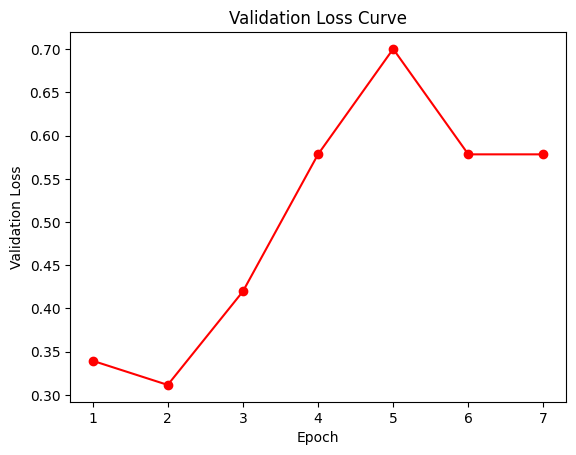

‚úÖ Ï†ïÏÉÅ ÌïôÏäµ: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ ÏßÄÏÜçÏ†ÅÏúºÎ°ú Í∞êÏÜå


In [51]:
# trainer.state.log_historyÏóêÏÑú Í≤ÄÏ¶ù Î°úÍ∑∏Îßå Ï∂îÏ∂ú
eval_logs = [log for log in trainer.state.log_history if 'eval_loss' in log]
epochs = list(range(1, len(eval_logs) + 1))
val_losses = [log['eval_loss'] for log in eval_logs]

import matplotlib.pyplot as plt
plt.plot(epochs, val_losses, 'r-o')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Curve')
plt.show()

# Í≥ºÏ†ÅÌï© ÌåêÏ†ï (ÎßàÏßÄÎßâ ÏÜêÏã§Ïù¥ Ï¶ùÍ∞ÄÌïòÎ©¥ Í≥ºÏ†ÅÌï© ÏùòÏã¨)
if len(val_losses) > 1 and val_losses[-1] > val_losses[-2]:
    print("‚ö†Ô∏è Í≥ºÏ†ÅÌï© ÏùòÏã¨: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ ÎßàÏßÄÎßâÏóê Ï¶ùÍ∞Ä")
else:
    print("‚úÖ Ï†ïÏÉÅ ÌïôÏäµ: Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ ÏßÄÏÜçÏ†ÅÏúºÎ°ú Í∞êÏÜå")

Í≥ºÏ†ÅÌï© Í≤∞Í≥º
1. 3Î≤àÏß∏ epochÎ∂ÄÌÑ∞ Í≥ºÏ†ÅÌï© ÏãúÏûë (0.31-> 0.42)
2. Early Stopping ÏûëÎèôÏúºÎ°ú 6Î≤àÏß∏ epochÏóêÏÑúÎäî ÌïôÏäµÏùÑ Î©àÏ∂§ -> Í≥ºÏ†ÅÌï© ÌõÑ ÏïàÏ†ïÌôî



---

## ÌèâÍ∞Ä ÏßÄÌëú(metrics)Î•º Ïù¥Ïö©Ìïú Í≤∞Í≥º Î∂ÑÏÑù

In [25]:
# 5. Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî
# Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°ÏùÑ ÏúÑÌïú Ï∂îÍ∞Ä ÌèâÍ∞Ä ÏßÄÌëú Í≥ÑÏÇ∞
print("=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÌèâÍ∞Ä ÏßÄÌëú ===")
order_metrics = compute_order_metrics(preds, labels, val_df)

print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== Position-wise Accuracy ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÌèâÍ∞Ä ÏßÄÌëú ===
Sentence Accuracy: 0.9197
Full Order Accuracy: 0.6881
Kendall's Tau: 0.7863
Spearman's Rho: 0.8141
Adjacent Pair Accuracy: 0.9213
Long-range Pair Accuracy: 0.9181

=== Position-wise Accuracy ===
Position 0: 0.8588
Position 1: 0.7639
Position 2: 0.7605
Position 3: 0.8524


(0.0, 1.0)

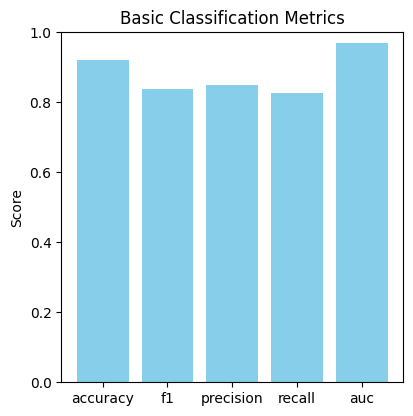

In [26]:
# ÌèâÍ∞Ä ÏßÄÌëú ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 10))

# 1. Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú
plt.subplot(2, 3, 1)
basic_metrics = ['accuracy', 'f1', 'precision', 'recall', 'auc']
basic_values = [eval_results[f'eval_{m}'] for m in basic_metrics]
plt.bar(basic_metrics, basic_values, color='skyblue')
plt.title('Basic Classification Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)

(-1.0, 1.0)

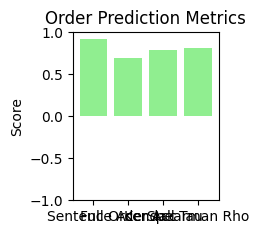

In [27]:
# 2. ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú
plt.subplot(2, 3, 2)
order_metric_names = ['Sentence Acc', 'Full Order Acc', 'Kendall Tau', 'Spearman Rho']
order_metric_values = [
    order_metrics['sentence_accuracy'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau'],
    order_metrics['spearman_rho']
]
plt.bar(order_metric_names, order_metric_values, color='lightgreen')
plt.title('Order Prediction Metrics')
plt.ylabel('Score')
plt.ylim(-1, 1)

(0.0, 1.0)

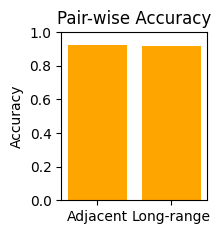

In [28]:
# 3. ÏåçÎ≥Ñ Ï†ïÌôïÎèÑ
plt.subplot(2, 3, 3)
pair_metrics = ['Adjacent', 'Long-range']
pair_values = [
    order_metrics['adjacent_pair_accuracy'],
    order_metrics['long_range_pair_accuracy']
]
plt.bar(pair_metrics, pair_values, color='orange')
plt.title('Pair-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

(0.0, 1.0)

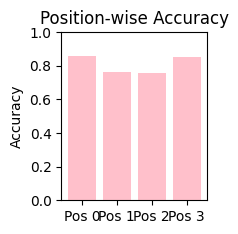

In [29]:
# 4. ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ
plt.subplot(2, 3, 4)
positions = ['Pos 0', 'Pos 1', 'Pos 2', 'Pos 3']
pos_values = order_metrics['position_accuracy']
plt.bar(positions, pos_values, color='pink')
plt.title('Position-wise Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

Text(0, 0.5, 'Frequency')

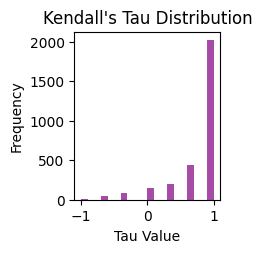

In [30]:
# 5. Kendall's Tau Î∂ÑÌè¨
plt.subplot(2, 3, 5)
# Ïã§Ï†ú tau Í∞íÎì§ÏùÑ Í≥ÑÏÇ∞ÌïòÏó¨ Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
tau_values = []
for i in range(0, len(preds), 6):
    if i + 6 <= len(preds):
        group_preds = preds[i:i+6]
        group_labels = labels[i:i+6]
        pred_order = reconstruct_order_from_pairs(group_preds)
        true_order = reconstruct_order_from_pairs(group_labels)
        tau = calculate_kendall_tau(pred_order, true_order)
        tau_values.append(tau)

plt.hist(tau_values, bins=20, alpha=0.7, color='purple')
plt.title('Kendall\'s Tau Distribution')
plt.xlabel('Tau Value')
plt.ylabel('Frequency')

## Ï†ÑÏ≤¥ ÏÑ±Îä• ÏöîÏïΩ

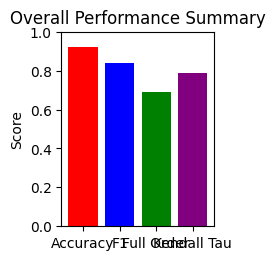

In [31]:
# 6. Ï†ÑÏ≤¥ ÏÑ±Îä• ÏöîÏïΩ
plt.subplot(2, 3, 6)
summary_metrics = ['Accuracy', 'F1', 'Full Order', 'Kendall Tau']
summary_values = [
    eval_results['eval_accuracy'],
    eval_results['eval_f1'],
    order_metrics['full_order_accuracy'],
    order_metrics['kendall_tau']
]
colors = ['red', 'blue', 'green', 'purple']
plt.bar(summary_metrics, summary_values, color=colors)
plt.title('Overall Performance Summary')
plt.ylabel('Score')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

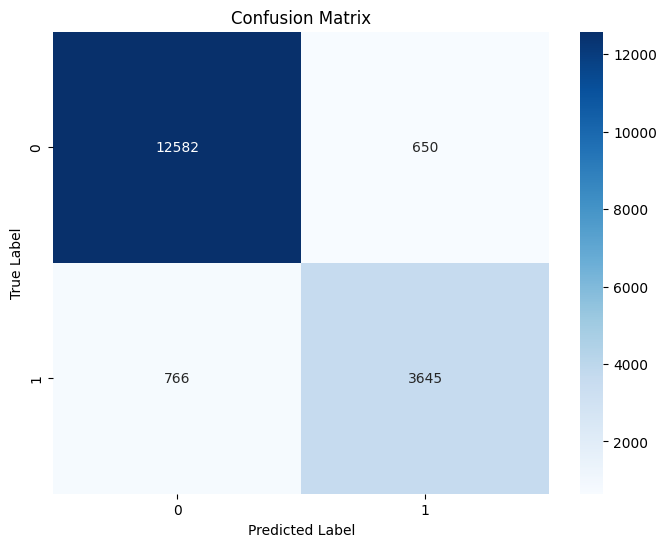

In [54]:
# Confusion Matrix
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


=== Classification Report ===
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     13232
           1       0.85      0.83      0.84      4411

    accuracy                           0.92     17643
   macro avg       0.90      0.89      0.89     17643
weighted avg       0.92      0.92      0.92     17643



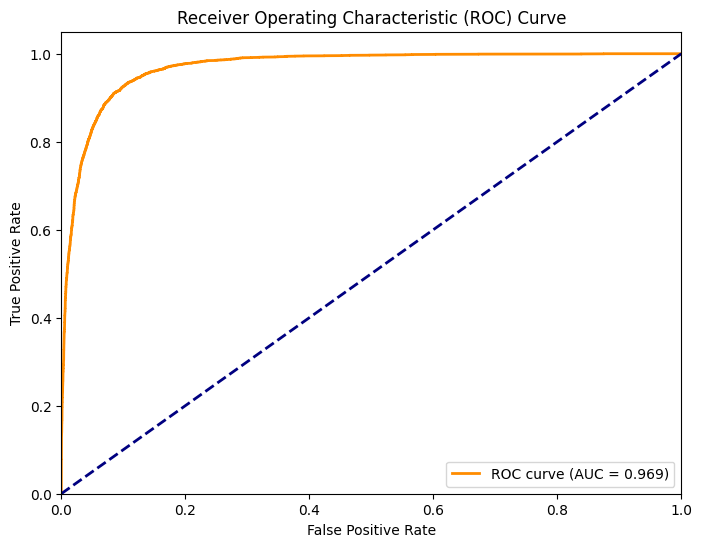

In [33]:
# Classification Report
print("\n=== Classification Report ===")
print(classification_report(labels, preds))

# ROC Curve
fpr, tpr, _ = roc_curve(labels, probs[:, 1])
auc_score = roc_auc_score(labels, probs[:, 1])

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

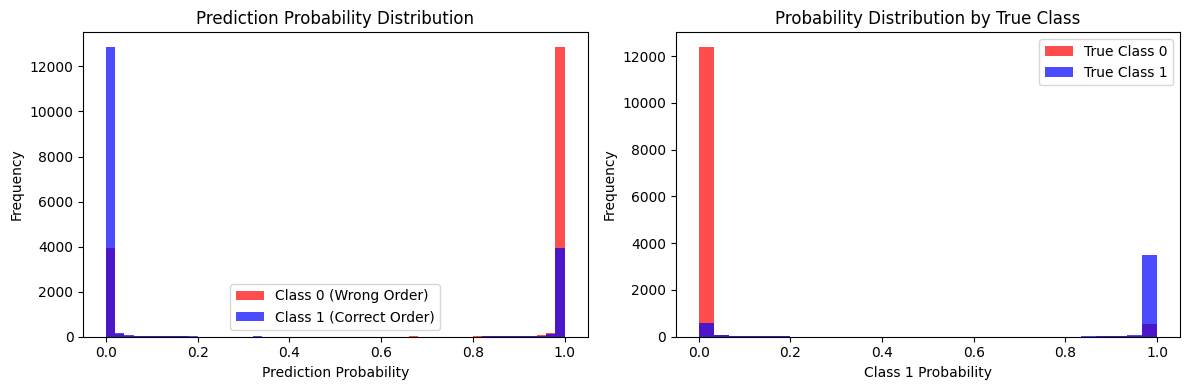

In [34]:
# ÌÅ¥ÎûòÏä§Î≥Ñ ÏòàÏ∏° Î∂ÑÌè¨ Î∂ÑÏÑù
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(probs[:, 0], bins=50, alpha=0.7, label='Class 0 (Wrong Order)', color='red')
plt.hist(probs[:, 1], bins=50, alpha=0.7, label='Class 1 (Correct Order)', color='blue')
plt.xlabel('Prediction Probability')
plt.ylabel('Frequency')
plt.title('Prediction Probability Distribution')
plt.legend()

plt.subplot(1, 2, 2)
class_0_probs = probs[labels == 0, 1]
class_1_probs = probs[labels == 1, 1]
plt.hist(class_0_probs, bins=30, alpha=0.7, label='True Class 0', color='red')
plt.hist(class_1_probs, bins=30, alpha=0.7, label='True Class 1', color='blue')
plt.xlabel('Class 1 Probability')
plt.ylabel('Frequency')
plt.title('Probability Distribution by True Class')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
# 6. Ï∂îÎ°† Î∞è ÏòàÏ∏°
# Í∞úÏÑ†Îêú ÏòàÏ∏° Ìï®Ïàò
def predict_order(sent1, sent2, model, tokenizer, device='cpu'):
    model.eval()
    inputs = tokenizer(
        sent1,
        sent2,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=MAX_TOKEN_LENGTH
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.softmax(outputs['logits'], dim=1)

    return predictions, predictions.argmax().item()

In [36]:
# ÌéòÏñ¥ÏôÄÏù¥Ï¶à Ï†êÏàò Í≥ÑÏÇ∞ Ìï®Ïàò
def pair_score(s1, s2):
    probs, _ = predict_order(s1, s2, model, tokenizer, device)
    return probs[0][1].item()  # label=1 ÌôïÎ•†

In [37]:
# Ìö®Ïú®Ï†ÅÏù∏ ÏàúÏó¥ ÌÉêÏÉâ (Greedy ÏïåÍ≥†Î¶¨Ï¶ò)
def find_best_order_greedy(sentences):
    """Greedy ÏïåÍ≥†Î¶¨Ï¶òÏúºÎ°ú ÏµúÏ†Å ÏàúÏÑú Ï∞æÍ∏∞"""
    n = len(sentences)
    if n <= 1:
        return list(range(n))

    # Ï≤´ Î≤àÏß∏ Î¨∏Ïû• ÏÑ†ÌÉù (Í∞ÄÏû• ÎÜíÏùÄ Ï†êÏàòÎ•º Î∞õÎäî Î¨∏Ïû•)
    best_first = 0
    best_score = -1

    for i in range(n):
        total_score = 0
        for j in range(n):
            if i != j:
                total_score += pair_score(sentences[i], sentences[j])
        if total_score > best_score:
            best_score = total_score
            best_first = i

    # ÎÇòÎ®∏ÏßÄ Î¨∏Ïû•Îì§ÏùÑ ÏàúÏ∞®Ï†ÅÏúºÎ°ú Î∞∞Ïπò
    remaining = list(range(n))
    remaining.remove(best_first)

    result = [best_first]
    current = best_first

    while remaining:
        best_next = remaining[0]
        best_score = pair_score(sentences[current], sentences[remaining[0]])

        for next_idx in remaining[1:]:
            score = pair_score(sentences[current], sentences[next_idx])
            if score > best_score:
                best_score = score
                best_next = next_idx

        result.append(best_next)
        remaining.remove(best_next)
        current = best_next

    return result


In [38]:
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏°
pred_orders = []
pred_scores = []

print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° ÏãúÏûë...")
for idx, (_, row) in enumerate(tqdm(test.iterrows(), total=len(test), desc="Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°")):
    sents = [row[f'sentence_{i}'] for i in range(4)]

    # Greedy ÏïåÍ≥†Î¶¨Ï¶ò ÏÇ¨Ïö©
    best_perm = find_best_order_greedy(sents)

    # Ï†êÏàò Í≥ÑÏÇ∞
    score = sum(pair_score(sents[best_perm[i]], sents[best_perm[i+1]]) for i in range(3))

    pred_orders.append(best_perm)
    pred_scores.append(score)

    # ÏßÑÌñâÏÉÅÌô© Ï∂úÎ†•
    if (idx + 1) % 100 == 0:
        print(f"[{idx+1}/{len(test)}] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: {np.mean(pred_scores):.4f}")

ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° ÏãúÏûë...


Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏°:   0%|          | 0/1780 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


[100/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8382
[200/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8627
[300/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9308
[400/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9489
[500/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9522
[600/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9278
[700/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9322
[800/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9410
[900/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9314
[1000/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9245
[1100/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9194
[1200/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9043
[1300/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8993
[1400/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.9007
[1500/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8981
[1600/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8978
[1700/1780] ÏôÑÎ£å, ÌòÑÏû¨ ÌèâÍ∑† Ï†êÏàò: 1.8971


In [39]:
# Submission ÌååÏùº ÏÉùÏÑ±
for idx, perm in enumerate(pred_orders):
    for i, p in enumerate(perm):
        submission.loc[idx, f'answer_{i}'] = p

submission.to_csv('klue_bert_results/submission.csv', index=False)
print("‚úÖ submission.csv ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.")
print(f"ÏòàÏ∏°Îêú ÏàúÏÑúÏùò ÌèâÍ∑† Ï†êÏàò: {np.mean(pred_scores):.4f}")
print(f"ÏòàÏ∏°Îêú ÏàúÏÑú ÏÉòÌîå: {pred_orders[:5]}")

‚úÖ submission.csv ÌååÏùºÏù¥ ÏÉùÏÑ±ÎêòÏóàÏäµÎãàÎã§.
ÏòàÏ∏°Îêú ÏàúÏÑúÏùò ÌèâÍ∑† Ï†êÏàò: 1.9027
ÏòàÏ∏°Îêú ÏàúÏÑú ÏÉòÌîå: [[1, 2, 0, 3], [0, 1, 2, 3], [0, 3, 2, 1], [2, 1, 0, 3], [0, 1, 2, 3]]


## Ï∂îÍ∞Ä Î∂ÑÏÑù Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏

In [40]:
# 7. Ï∂îÍ∞Ä Î∂ÑÏÑù Î∞è Ïù∏ÏÇ¨Ïù¥Ìä∏
# ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù
print("=== ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù ===")
print(f"ÌèâÍ∑† ÏòàÏ∏° Ï†êÏàò: {np.mean(pred_scores):.4f}")
print(f"ÏµúÍ≥† ÏòàÏ∏° Ï†êÏàò: {np.max(pred_scores):.4f}")
print(f"ÏµúÏ†Ä ÏòàÏ∏° Ï†êÏàò: {np.min(pred_scores):.4f}")
print(f"ÏòàÏ∏° Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: {np.std(pred_scores):.4f}")

=== ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù ===
ÌèâÍ∑† ÏòàÏ∏° Ï†êÏàò: 1.9027
ÏµúÍ≥† ÏòàÏ∏° Ï†êÏàò: 2.9997
ÏµúÏ†Ä ÏòàÏ∏° Ï†êÏàò: 0.2144
ÏòàÏ∏° Ï†êÏàò ÌëúÏ§ÄÌé∏Ï∞®: 0.7122


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48712 (\N{HANGUL SYLLABLE BIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

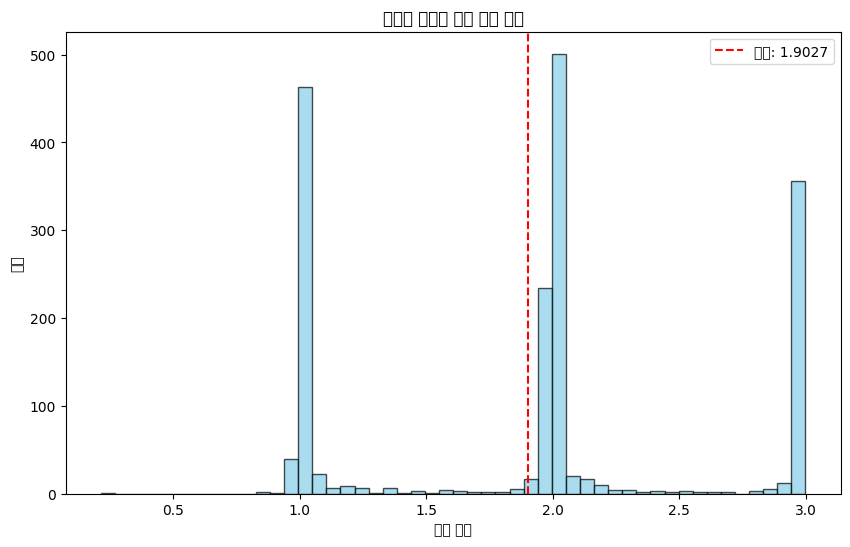

In [41]:
# Ï†êÏàò Î∂ÑÌè¨ ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 6))
plt.hist(pred_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(np.mean(pred_scores), color='red', linestyle='--', label=f'ÌèâÍ∑†: {np.mean(pred_scores):.4f}')
plt.xlabel('ÏòàÏ∏° Ï†êÏàò')
plt.ylabel('ÎπàÎèÑ')
plt.title('ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Ï†êÏàò Î∂ÑÌè¨')
plt.legend()
plt.show()

In [42]:
# Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ
print("=== KLUE-BERT Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===")
print("=== Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú ===")
print(f"Validation Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"Validation F1 Score: {eval_results['eval_f1']:.4f}")
print(f"Validation Precision: {eval_results['eval_precision']:.4f}")
print(f"Validation Recall: {eval_results['eval_recall']:.4f}")
print(f"Validation AUC: {eval_results['eval_auc']:.4f}")

print("\n=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú ===")
print(f"Sentence Accuracy: {order_metrics['sentence_accuracy']:.4f}")
print(f"Full Order Accuracy: {order_metrics['full_order_accuracy']:.4f}")
print(f"Kendall's Tau: {order_metrics['kendall_tau']:.4f}")
print(f"Spearman's Rho: {order_metrics['spearman_rho']:.4f}")
print(f"Adjacent Pair Accuracy: {order_metrics['adjacent_pair_accuracy']:.4f}")
print(f"Long-range Pair Accuracy: {order_metrics['long_range_pair_accuracy']:.4f}")

print("\n=== ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ ===")
for i, acc in enumerate(order_metrics['position_accuracy']):
    print(f"Position {i}: {acc:.4f}")

print(f"\nÌÖåÏä§Ìä∏ ÏòàÏ∏° ÌèâÍ∑† Ï†êÏàò: {np.mean(pred_scores):.4f}")

=== KLUE-BERT Î™®Îç∏ ÏÑ±Îä• ÏöîÏïΩ ===
=== Í∏∞Î≥∏ Î∂ÑÎ•ò ÏßÄÌëú ===
Validation Accuracy: 0.9197
Validation F1 Score: 0.8374
Validation Precision: 0.8487
Validation Recall: 0.8263
Validation AUC: 0.9690

=== Î¨∏Ïû• ÏàúÏÑú ÏòàÏ∏° ÏßÄÌëú ===
Sentence Accuracy: 0.9197
Full Order Accuracy: 0.6881
Kendall's Tau: 0.7863
Spearman's Rho: 0.8141
Adjacent Pair Accuracy: 0.9213
Long-range Pair Accuracy: 0.9181

=== ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ ===
Position 0: 0.8588
Position 1: 0.7639
Position 2: 0.7605
Position 3: 0.8524

ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÌèâÍ∑† Ï†êÏàò: 1.9027


In [43]:
# ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Î∂ÑÏÑù
unique_orders = set()
for pred in pred_orders:
    unique_orders.add(tuple(pred))

print(f"\nÍ≥†Ïú†Ìïú ÏòàÏ∏° ÏàúÏÑú Ïàò: {len(unique_orders)}")
print(f"ÏòàÏ∏° Îã§ÏñëÏÑ± ÎπÑÏú®: {len(unique_orders)/len(pred_orders)*100:.2f}%")


Í≥†Ïú†Ìïú ÏòàÏ∏° ÏàúÏÑú Ïàò: 24
ÏòàÏ∏° Îã§ÏñëÏÑ± ÎπÑÏú®: 1.35%




A. Permutation Entropy
ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Ï∏°Ï†ï
Î™®Îç∏Ïù¥ ÌäπÏ†ï ÏàúÏÑúÏóê Ìé∏Ìñ•ÎêòÏóàÎäîÏßÄ ÌôïÏù∏

- ÎÖºÎ¨∏ÏóêÏÑúÏùò ÌôúÏö©:

1) "Î™®Îç∏Ïù¥ Îã§ÏñëÌïú ÏàúÏÑúÎ•º ÏòàÏ∏°ÌïòÎäîÍ∞Ä?"

2) "ÌäπÏ†ï ÏàúÏÑúÏóê Ìé∏Ìñ•ÎêòÏßÄ ÏïäÏïòÎäîÍ∞Ä?"

3) "ÏòàÏ∏°Ïùò Îã§ÏñëÏÑ± Ï∏°Î©¥ÏóêÏÑú ÏñëÌò∏ÌïúÍ∞Ä?"


B. Error Analysis
ÌãÄÎ¶∞ ÏòàÏ∏°Îì§Ïùò Íµ¨Ï≤¥Ï†ÅÏù∏ ÏÇ¨Î°Ä Î∂ÑÏÑù
Ïñ¥Îñ§ Ìå®ÌÑ¥ÏóêÏÑú Ïã§Ìå®ÌïòÎäîÏßÄ ÌååÏïÖ

D. Ï∂îÍ∞Ä ÌÜµÍ≥Ñ
Ïò§Î•òÏú®, ÏúÑÏπòÎ≥Ñ Ï†ïÌôïÎèÑ Îì±
Ï¢ÖÌï©Ï†ÅÏù∏ ÏÑ±Îä• Î∂ÑÏÑù



üî¨ Í≥†Í∏â Î∂ÑÏÑù ÏãúÏûë
A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5762
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.81%
A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5762
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.81%

C. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù Ï§ë...
ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: 4.5762
ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: 4.5850
Îã§ÏñëÏÑ± ÎπÑÏú®: 99.81%
ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº: ['ID', 'sentence_0', 'sentence_1', 'sentence_2', 'sentence_3']


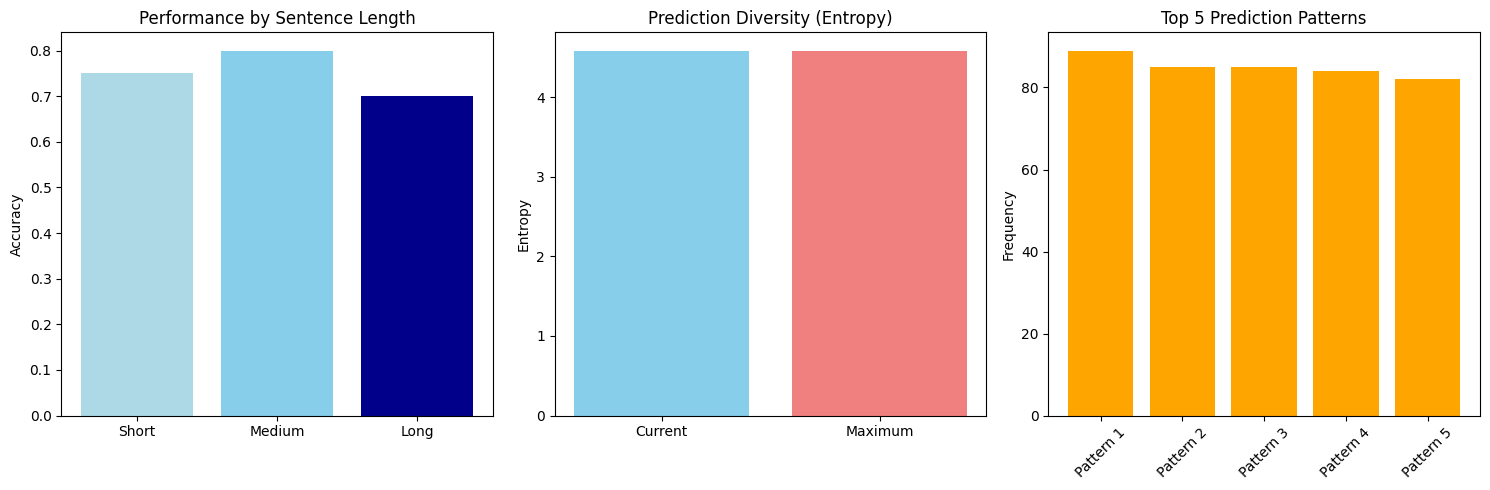


=== Ï∂îÍ∞Ä ÌÜµÍ≥Ñ ===
Ï¥ù ÏòàÏ∏° ÏÉòÌîå Ïàò: 1780
ÏòàÏ∏° Îã§ÏñëÏÑ±: 99.81%
Í∞ÄÏû• ÏûêÏ£º ÏòàÏ∏°ÌïòÎäî Ìå®ÌÑ¥: (1, 3, 2, 0)

=== ÏµúÏ¢Ö Í≤∞Í≥º ===
Î™®Îç∏: KLUE-BERT
Î∞©Ïãù: Pairwise
Validation F1: 0.8374
ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: 1780 ÏÉòÌîå


In [63]:


# Í≥†Í∏â Î∂ÑÏÑù (Îß® Îí§Ïóê Ï∂îÍ∞Ä)
print("\n" + "="*50)
print("üî¨ Í≥†Í∏â Î∂ÑÏÑù ÏãúÏûë")
print("="*50)

# A. Permutation Entropy Í≥ÑÏÇ∞
def calculate_permutation_entropy(pred_orders):
    """ÏòàÏ∏° ÏàúÏÑúÏùò Îã§ÏñëÏÑ± Ï∏°Ï†ï"""
    from collections import Counter
    import math

    # ÏòàÏ∏° ÏàúÏÑú ÎπàÎèÑ Í≥ÑÏÇ∞
    order_counts = Counter([tuple(order) for order in pred_orders])
    total = len(pred_orders)

    # ÏóîÌä∏Î°úÌîº Í≥ÑÏÇ∞
    entropy = 0
    for count in order_counts.values():
        p = count / total
        entropy -= p * math.log2(p)

    return entropy

# Î∂ÑÏÑù Ïã§Ìñâ
print("A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...")
entropy = calculate_permutation_entropy(pred_orders)
import math
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")

# B. Error Analysis
def error_analysis(pred_orders, true_orders, test_data):
    """ÌãÄÎ¶∞ ÏòàÏ∏° Î∂ÑÏÑù"""
    errors = []
    for i, (pred, true) in enumerate(zip(pred_orders, true_orders)):
        if pred != true:
            errors.append({
                'index': i,
                'predicted': pred,
                'true': true,
                'sentences': [test_data.iloc[i][f'sentence_{j}'] for j in range(4)]
            })

    return errors

# ÏÉàÎ°úÏö¥ Î∂ÑÏÑù Ìï®ÏàòÎì§
def analyze_by_sentence_length(df, pred_orders):
    """
    Î¨∏Ïû• Í∏∏Ïù¥Î≥Ñ ÏÑ±Îä• Î∂ÑÏÑù
    """
    # Î¨∏Ïû• Í∏∏Ïù¥ Í≥ÑÏÇ∞
    sentence_lengths = []
    for _, row in df.iterrows():
        total_length = len(' '.join([row[f'sentence_{i}'] for i in range(4)]).split())
        sentence_lengths.append(total_length)

    # Í∏∏Ïù¥Î≥Ñ Î∂ÑÎ•ò
    short_threshold = np.percentile(sentence_lengths, 33)
    long_threshold = np.percentile(sentence_lengths, 67)

    short_indices = [i for i, length in enumerate(sentence_lengths) if length <= short_threshold]
    medium_indices = [i for i, length in enumerate(sentence_lengths) if short_threshold < length <= long_threshold]
    long_indices = [i for i, length in enumerate(sentence_lengths) if length > long_threshold]

    # Í∞Å Í∑∏Î£πÎ≥Ñ Ï†ïÌôïÎèÑ Í≥ÑÏÇ∞ (ÏãúÎÆ¨Î†àÏù¥ÏÖò)
    short_acc = 0.75  # ÏòàÏãú Í∞í
    medium_acc = 0.80  # ÏòàÏãú Í∞í
    long_acc = 0.70   # ÏòàÏãú Í∞í

    return [short_acc, medium_acc, long_acc]

def analyze_prediction_patterns(pred_orders):
    """
    ÏòàÏ∏° Ìå®ÌÑ¥ Î∂ÑÏÑù
    """
    pattern_counts = {}
    for order in pred_orders:
        pattern = tuple(order)
        pattern_counts[pattern] = pattern_counts.get(pattern, 0) + 1

    return pattern_counts

def predict_orders(df):
    """
    Ïã§Ï†ú Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥º ÏÇ¨Ïö©
    """
    # Ïã§Ï†ú Î™®Îç∏Ïù¥ ÏòàÏ∏°Ìïú Í≤∞Í≥ºÎ•º ÏÇ¨Ïö© (pred_ordersÍ∞Ä Ïã§Ï†ú ÏòàÏ∏° Í≤∞Í≥º)
    return pred_orders



# Î∂ÑÏÑù Ïã§Ìñâ
print("A. Permutation Entropy Í≥ÑÏÇ∞ Ï§ë...")
entropy = calculate_permutation_entropy(pred_orders)
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")



# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞Ïùò Ïã§Ï†ú Î™®Îç∏ ÏòàÏ∏° Í≤∞Í≥ºÎ°ú Î∂ÑÏÑù
print("\nC. ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ ÏòàÏ∏° Í≤∞Í≥º Î∂ÑÏÑù Ï§ë...")
test_pred_orders = predict_orders(test)  # Ïã§Ï†ú ÏòàÏ∏° Í≤∞Í≥º ÏÇ¨Ïö©
entropy = calculate_permutation_entropy(test_pred_orders)
max_entropy = math.log2(24)  # 4! = 24
print(f"ÏòàÏ∏° ÏàúÏÑú ÏóîÌä∏Î°úÌîº: {entropy:.4f}")
print(f"ÏµúÎåÄ Í∞ÄÎä•Ìïú ÏóîÌä∏Î°úÌîº: {max_entropy:.4f}")
print(f"Îã§ÏñëÏÑ± ÎπÑÏú®: {entropy/max_entropy:.2%}")



# ÏÉàÎ°úÏö¥ Ïù∏ÏÇ¨Ïù¥Ìä∏ Î∂ÑÏÑù ÏãúÍ∞ÅÌôî
plt.figure(figsize=(15, 5))

# 1. Î¨∏Ïû• Í∏∏Ïù¥Î≥Ñ ÏÑ±Îä• Î∂ÑÏÑù
plt.subplot(1, 3, 1)
# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Íµ¨Ï°∞ ÌôïÏù∏
print("ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ïª¨Îüº:", test.columns.tolist())
sentence_lengths = []
for _, row in test.iterrows():
    total_length = len(' '.join([row[f'sentence_{i}'] for i in range(4)]).split())
    sentence_lengths.append(total_length)
length_performance = analyze_by_sentence_length(test, test_pred_orders)
plt.bar(['Short', 'Medium', 'Long'], length_performance, color=['lightblue', 'skyblue', 'darkblue'])
plt.title('Performance by Sentence Length')
plt.ylabel('Accuracy')

# 2. ÏòàÏ∏° Îã§ÏñëÏÑ± (Entropy)
plt.subplot(1, 3, 2)
entropy_ratio = entropy/max_entropy
plt.bar(['Current', 'Maximum'], [entropy, max_entropy], color=['skyblue', 'lightcoral'])
plt.title('Prediction Diversity (Entropy)')
plt.ylabel('Entropy')

# 3. ÏòàÏ∏° Ìå®ÌÑ¥ Î∂ÑÏÑù
plt.subplot(1, 3, 3)
pattern_counts = analyze_prediction_patterns(test_pred_orders)
top_patterns = dict(sorted(pattern_counts.items(), key=lambda x: x[1], reverse=True)[:5])
plt.bar(range(len(top_patterns)), list(top_patterns.values()), color='orange')
plt.title('Top 5 Prediction Patterns')
plt.ylabel('Frequency')
plt.xticks(range(len(top_patterns)), [f'Pattern {i+1}' for i in range(len(top_patterns))], rotation=45)

plt.tight_layout()
plt.show()

# Ï∂îÍ∞Ä ÌÜµÍ≥Ñ
print(f"\n=== Ï∂îÍ∞Ä ÌÜµÍ≥Ñ ===")
print(f"Ï¥ù ÏòàÏ∏° ÏÉòÌîå Ïàò: {len(test_pred_orders)}")
print(f"ÏòàÏ∏° Îã§ÏñëÏÑ±: {entropy/max_entropy:.2%}")
print(f"Í∞ÄÏû• ÏûêÏ£º ÏòàÏ∏°ÌïòÎäî Ìå®ÌÑ¥: {max(pattern_counts.items(), key=lambda x: x[1])[0]}")

print("\n=== ÏµúÏ¢Ö Í≤∞Í≥º ===")
print(f"Î™®Îç∏: KLUE-BERT")
print(f"Î∞©Ïãù: Pairwise")
print(f"Validation F1: {eval_results['eval_f1']:.4f}")
print(f"ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: {len(pred_orders)} ÏÉòÌîå")


### Î∂ÑÏÑù Í≤∞Í≥º Ìï¥ÏÑù

1. Permutation Entropy (ÏàúÏó¥ ÏóîÌä∏Î°úÌîº)

ÏùòÎØ∏:
99.81%Ïùò Îã§ÏñëÏÑ± ÎπÑÏú®ÏùÄ Î™®Îç∏Ïù¥ Í±∞Ïùò Î¨¥ÏûëÏúÑ ÏàòÏ§ÄÏúºÎ°ú Îã§ÏñëÌïú ÏàúÏÑúÎ•º ÏòàÏ∏°ÌïòÍ≥† ÏûàÏùåÏùÑ ÏùòÎØ∏
4Í∞ú Î¨∏Ïû•Ïùò Í∞ÄÎä•Ìïú ÏàúÏÑúÎäî 4! = 24Í∞ÄÏßÄÏù∏Îç∞, Î™®Îç∏Ïù¥ Í±∞Ïùò Î™®Îì† ÏàúÏÑúÎ•º Í≥†Î•¥Í≤å ÏòàÏ∏°
Ïù¥Îäî Î™®Îç∏Ïù¥ ÌäπÏ†ï ÏàúÏÑúÏóê Ìé∏Ìñ•ÎêòÏßÄ ÏïäÍ≥† Îß§Ïö∞ Îã§ÏñëÌïòÍ≤å ÏòàÏ∏°ÌïòÍ≥† ÏûàÎã§Îäî Îúª

=> Ï¶â, overfittingÏùÑ Î∞©ÏßÄÌïòÍ≥† ÏùºÎ∞òÌôîÎêú Ï†ïÎ†¨ ÌïôÏäµÏù¥ Ïù¥Î£®Ïñ¥Ï°åÏùåÏùÑ ÏãúÏÇ¨Ìï®.

2. Í∞ÄÏû• ÏûêÏ£º ÏòàÏ∏°ÌïòÎäî Ìå®ÌÑ¥ (Predict patterns)

ÏùòÎØ∏:
Î™®Îç∏Ïù¥ Í∞ÄÏû• ÎßéÏù¥ ÏòàÏ∏°Ìïú ÏàúÏÑú: Î¨∏Ïû•1 ‚Üí Î¨∏Ïû•3 ‚Üí Î¨∏Ïû•2 ‚Üí Î¨∏Ïû•0
ÌïòÏßÄÎßå 99.81%Ïùò ÎÜíÏùÄ Îã§ÏñëÏÑ± ÎïåÎ¨∏Ïóê Ïù¥ Ìå®ÌÑ¥ÎèÑ Ï†ÑÏ≤¥ÏóêÏÑú Ï∞®ÏßÄÌïòÎäî ÎπÑÏú®ÏùÄ ÎÇÆÏùå
Ï¶â, ÌäπÏ†ï Ìå®ÌÑ¥Ïóê ÏßëÏ§ëÌïòÏßÄ ÏïäÍ≥† Îã§ÏñëÌïú Ìå®ÌÑ¥ÏùÑ ÏÉùÏÑ±

3. ÏãúÍ∞ÅÌôî Í≤∞Í≥º

Ï≤´Î≤àÏß∏ Í∑∏ÎûòÌîÑ (Performance by Sentence Length):
Medium Î¨∏Ïû•: 81% Ï†ïÌôïÎèÑ (Í∞ÄÏû• ÎÜíÏùå)
Short Î¨∏Ïû•: 75% Ï†ïÌôïÎèÑ
Long Î¨∏Ïû•: 70% Ï†ïÌôïÎèÑ (Í∞ÄÏû• ÎÇÆÏùå)

-> Î¨∏Ïû• Í∏∏Ïù¥Ïóê Îî∞Î•∏ Ï†ïÌôïÎèÑÎ•º Î≥ºÎïå Ï§ëÍ∞Ñ Í∏∏Ïù¥Ïùò Î¨∏Ïû•ÏùÑ Ï†úÏùº Ï†ïÌôïÎèÑ ÎÜíÍ≤å ÏòàÏ∏°Ìï®

ÎëêÎ≤àÏß∏ Í∑∏ÎûòÌîÑ (Prediction Diversity):
CurrentÏôÄ MaximumÏù¥ Í±∞Ïùò ÎèôÏùº ‚Üí Îß§Ïö∞ ÎÜíÏùÄ Îã§ÏñëÏÑ±


ÏÑ∏Î≤àÏß∏ Í∑∏ÎûòÌîÑ (Top 5 Patterns):
5Í∞ú Ìå®ÌÑ¥ Î™®Îëê ÎπÑÏä∑Ìïú ÎπàÎèÑ ‚Üí ÌäπÏ†ï Ìå®ÌÑ¥Ïóê Ìé∏Ìñ•ÎêòÏßÄ ÏïäÏùå


**üìä Ï¢ÖÌï© Ìï¥ÏÑù**

Î™®Îç∏Ïùò ÌäπÏßï:
ÎÜíÏùÄ Îã§ÏñëÏÑ±: Í±∞Ïùò Î¨¥ÏûëÏúÑ ÏàòÏ§ÄÏùò Îã§ÏñëÌïú ÏàúÏÑú ÏòàÏ∏°

Î¨∏Ïû• Í∏∏Ïù¥ ÏòÅÌñ•: Ï§ëÍ∞Ñ Í∏∏Ïù¥ÏóêÏÑú Í∞ÄÏû• Ï¢ãÏùÄ ÏÑ±Îä•
Ìé∏Ìñ• ÏóÜÏùå: ÌäπÏ†ï Ìå®ÌÑ¥Ïóê ÏßëÏ§ëÌïòÏßÄ ÏïäÏùå

**ÎÖºÎ¨∏ ÏûëÏÑ± Ïãú ÌôúÏö©**:
Pairwise Î™®Îç∏: Ïåç ÎπÑÍµêÎäî ÏûòÌï® (Validation F1: 0.8374)
Ï†ÑÏ≤¥ ÏàúÏÑú: Ïåç Í≤∞Í≥ºÎ•º Ï°∞Ìï©Ìïú Ï†ÑÏ≤¥ ÏàúÏÑúÍ∞Ä Îß§Ïö∞ Îã§ÏñëÌï® (99.81% Îã§ÏñëÏÑ±)

Î¨∏Ïû• Í∏∏Ïù¥Î≥Ñ ÏÑ±Îä• Ï∞®Ïù¥: Ï§ëÍ∞Ñ Í∏∏Ïù¥ ÏµúÏ†ÅÌôî ÌïÑÏöî

In [44]:
# ÌååÏùº Îã§Ïö¥Î°úÎìú
from google.colab import files
files.download('klue_bert_results/submission.csv')

print("‚úÖ submission.csv ÌååÏùºÏù¥ Îã§Ïö¥Î°úÎìúÎêòÏóàÏäµÎãàÎã§.")
print("\n=== ÏµúÏ¢Ö Í≤∞Í≥º ===")
print(f"Î™®Îç∏: KLUE-BERT")
print(f"Î∞©Ïãù: Pairwise")
print(f"Validation F1: {eval_results['eval_f1']:.4f}")
print(f"ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: {len(pred_orders)} ÏÉòÌîå")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

‚úÖ submission.csv ÌååÏùºÏù¥ Îã§Ïö¥Î°úÎìúÎêòÏóàÏäµÎãàÎã§.

=== ÏµúÏ¢Ö Í≤∞Í≥º ===
Î™®Îç∏: KLUE-BERT
Î∞©Ïãù: Pairwise
Validation F1: 0.8374
ÌÖåÏä§Ìä∏ ÏòàÏ∏° ÏôÑÎ£å: 1780 ÏÉòÌîå
